In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from glob import glob
import cv2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
img = cv2.imread('/content/gdrive/MyDrive/NNDL/Project/masked-dataset/test/angry/S127_010_00000017.png')
print(img.shape)

(48, 48, 3)


In [ ]:
train_path = '/content/gdrive/MyDrive/NNDL/Project/masked-dataset/train'
test_path = '/content/gdrive/MyDrive/NNDL/Project/masked-dataset/test'

In [ ]:
IMAGE_SIZE = [48,48]

In [ ]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"

In [ ]:
print('total images for training :', count(train_path))
print('total images for test :', count(test_path))

total images for training : /content/gdrive/MyDrive/NNDL/Project/masked-dataset/train : 300files
total images for test : /content/gdrive/MyDrive/NNDL/Project/masked-dataset/test : 126files


In [ ]:
folders = glob('/content/gdrive/MyDrive/NNDL/Project/masked-dataset/train/*')
print(len(folders))

3


In [ ]:
BATCH_SIZE = 32

train_generator = ImageDataGenerator(validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessin

In [ ]:
class_subset = sorted(os.listdir('/content/gdrive/MyDrive/NNDL/Project/masked-dataset/train'))
print(class_subset)
traingen = train_generator.flow_from_directory(train_path,
                                               target_size=(48,48),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=5)

validgen = train_generator.flow_from_directory(train_path,
                                               target_size=(48,48),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=4)

testgen = test_generator.flow_from_directory(test_path,
                                             target_size=(48,48),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=4)

['angry', 'happy', 'sad']
Found 256 images belonging to 3 classes.
Found 44 images belonging to 3 classes.
Found 126 images belonging to 3 classes.


# VGG16 + TRANSFER LEARNING

In [ ]:
from keras.applications.vgg16 import VGG16
model = Sequential()
model1 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in model1.layers:
  layer.trainable = False

In [ ]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
batnorm = layers.BatchNormalization()
dropout = layers.Dropout(0.20)
prediction_layer = layers.Dense(3, activation='softmax')


vgg16 = models.Sequential([
    model1,
    flatten_layer,
    batnorm,
    dropout,
    prediction_layer
])

In [ ]:
vgg16.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 14,718,275
Trainable params: 2,563
Non-trainable params: 14,715,712
_____________________________________

In [ ]:
optimizer=Adam(learning_rate=0.001)
vgg16.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


from keras.callbacks import ModelCheckpoint, EarlyStopping
optim_1 = Adam(learning_rate=0.001)
#n_classes=3

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='/content/gdrive/MyDrive/NNDL/Project/masked-dataset/vgg16.h5',
                                  save_best_only=True,
                                  monitor='val_accuracy',
                                  mode='max',
                                  verbose=1)

vgg_history = vgg16.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1], 
                            verbose=1)

Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 1.3968 - accuracy: 0.3828
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/gdrive/MyDrive/NNDL/Project/masked-dataset/vgg16.h5
8/8 [==============================] - 2s 175ms/step - loss: 1.3968 - accuracy: 0.3828 - val_loss: 3.3636 - val_accuracy: 0.5000
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 1.1536 - accuracy: 0.4570
Epoch 2: val_accuracy improved from 0.50000 to 0.59375, saving model to /content/gdrive/MyDrive/NNDL/Project/masked-dataset/vgg16.h5
8/8 [==============================] - 1s 132ms/step - loss: 1.1536 - accuracy: 0.4570 - val_loss: 2.1401 - val_accuracy: 0.5938
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 0.9884 - accuracy: 0.5703
Epoch 3: val_accuracy did not improve from 0.59375
8/8 [==============================] - 1s 93ms/step - loss: 0.9884 - accuracy: 0.5703 - val_loss: 1.9047 - val_accuracy: 0.5312
Epoch 4/50
8/8 [========

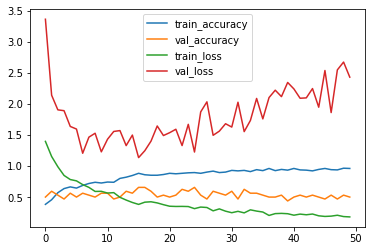

In [ ]:
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.legend(['train_accuracy','val_accuracy','train_loss','val_loss'])

In [ ]:
import numpy as np
# Generate predictions
vgg16.load_weights('/content/gdrive/MyDrive/NNDL/Project/masked-dataset/vgg16.h5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg16.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy using TL: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy using TL: 49.21%


In [ ]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/NNDL/Project/masked-dataset/vgg16.h5')

In [ ]:
true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [ ]:
print(confusion_matrix(true_classes, vgg_pred_classes))

[[14 18  3]
 [ 6 44  7]
 [17 13  4]]


In [ ]:
print(classification_report(true_classes, vgg_pred_classes))

              precision    recall  f1-score   support

           0       0.38      0.40      0.39        35
           1       0.59      0.77      0.67        57
           2       0.29      0.12      0.17        34

    accuracy                           0.49       126
   macro avg       0.42      0.43      0.41       126
weighted avg       0.45      0.49      0.45       126



In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
model = tf.keras.models.load_model('/content/gdrive/MyDrive/NNDL/Project/masked-dataset/vgg16.h5')

In [ ]:
img = image.load_img('/content/gdrive/MyDrive/NNDL/Project/sample/happy_resized.jpg',target_size=(48,48))

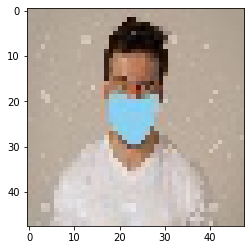

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

In [ ]:
from keras.applications.vgg16 import preprocess_input
img_preprocessed = preprocess_input(img_batch)

In [ ]:
prediction = model.predict(img_preprocessed)

In [ ]:
prediction

array([[9.9913424e-01, 8.6578092e-04, 1.4101881e-15]], dtype=float32)

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
model = tf.keras.models.load_model('/content/gdrive/MyDrive/NNDL/Project/masked-dataset/vgg16.h5')

In [ ]:
img = image.load_img('/content/gdrive/MyDrive/NNDL/Project/sample/sad_resized.jpg',target_size=(48,48))

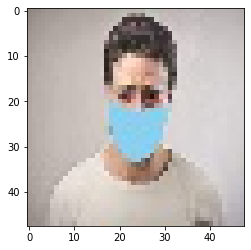

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

In [ ]:
from keras.applications.vgg16 import preprocess_input
img_preprocessed = preprocess_input(img_batch)

In [ ]:
prediction = model.predict(img_preprocessed)

In [ ]:
prediction

array([[5.8200592e-01, 4.1799408e-01, 7.7509164e-09]], dtype=float32)

# **VGG16**

In [ ]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Dropout
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(48,48,3)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2),data_format="channels_last",padding='same'))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2),data_format="channels_last",padding='same'))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2),data_format="channels_last",padding='same'))


model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2),data_format="channels_last",padding='same'))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 50, 50, 3)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 18, 18, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 64)          36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 64)         0         
 )                                                               
                                                        

In [ ]:
optimizer=Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


from keras.callbacks import ModelCheckpoint, EarlyStopping
optim_1 = Adam(learning_rate=0.001)
#n_classes=3

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='/content/gdrive/MyDrive/NNDL/Project/masked-dataset/vgg16_1.h5',
                                  save_best_only=True,
                                  monitor='val_accuracy',
                                  mode='max',
                                  verbose=1)
vgg_history = model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1], 
                            verbose=1)

Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 1.0497 - accuracy: 0.4336
Epoch 1: val_accuracy improved from -inf to 0.53125, saving model to /content/gdrive/MyDrive/NNDL/Project/masked-dataset/vgg16_1.h5
8/8 [==============================] - 42s 5s/step - loss: 1.0497 - accuracy: 0.4336 - val_loss: 1.0578 - val_accuracy: 0.5312
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 1.0435 - accuracy: 0.5000
Epoch 2: val_accuracy improved from 0.53125 to 0.56250, saving model to /content/gdrive/MyDrive/NNDL/Project/masked-dataset/vgg16_1.h5
8/8 [==============================] - 3s 312ms/step - loss: 1.0435 - accuracy: 0.5000 - val_loss: 1.0175 - val_accuracy: 0.5625
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 1.0155 - accuracy: 0.5000
Epoch 3: val_accuracy did not improve from 0.56250
8/8 [==============================] - 1s 112ms/step - loss: 1.0155 - accuracy: 0.5000 - val_loss: 0.9902 - val_accuracy: 0.5312
Epoch 4/50
8/8 [=====

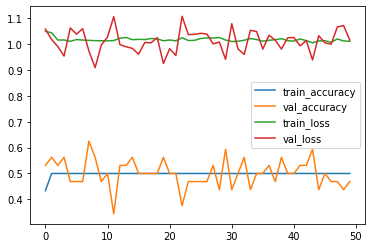

In [ ]:
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.legend(['train_accuracy','val_accuracy','train_loss','val_loss'])

In [ ]:
import numpy as np
# Generate predictions
model.load_weights('/content/gdrive/MyDrive/NNDL/Project/masked-dataset/vgg16_1.h5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy: 45.24%


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(true_classes, vgg_pred_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.45      1.00      0.62        57
           2       0.00      0.00      0.00        34

    accuracy                           0.45       126
   macro avg       0.15      0.33      0.21       126
weighted avg       0.20      0.45      0.28       126



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(confusion_matrix(true_classes, vgg_pred_classes))

[[ 0 35  0]
 [ 0 57  0]
 [ 0 34  0]]


In [ ]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/NNDL/Project/masked-dataset/vgg16_1.h5')
img = image.load_img('/content/gdrive/MyDrive/NNDL/Project/sample/happy1_resized.jpg',target_size=(48,48))


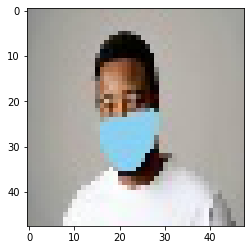

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
from keras.applications.vgg16 import preprocess_input
img_preprocessed = preprocess_input(img_batch)

In [ ]:
prediction = model.predict(img_preprocessed)


In [ ]:
prediction

array([[0.33037588, 0.501797  , 0.16782707]], dtype=float32)